# Implementando uma MLP para resolver o problema de reconhecimento de caracteres

## Importações do projeto
Para este projeto, nós utilizamos as seguintes bibliotecas:
- pandas
- numpy
- scikit-learn
- seaborn

In [364]:
import pandas as pd
import numpy as np
import random

## Imporatação dos conjuntos de dados
Cada conjunto de dados possui 21 letras, em que cada letra pode ser uma dentre ['A','B','C','D','E','J','K'].

Os 3 conjuntos utilizados foram:
 - limpo:  cunjunto de dados em que as letras não possuem ruido algum;
 - ruido1: conjunto de dados em que as letras possuem algum tipo de ruido;
 - ruido2: o mesmo caso do 'ruido1', porém com ruidos diferentes

In [365]:
limpo = pd.read_csv('datasets/caracteres-limpo.csv', header=None)

ruido1 = pd.read_csv('datasets/caracteres-ruido.csv', header=None)

ruido2 = pd.read_csv('datasets/caracteres-ruido2.csv', header=None)

ruido1.sample()

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
10,-1,1,1,1,1,-1,-1,1,-1,-1,...,1,-1,-1,-1,-1,-1,1,-1,-1,-1


## Funções

Neste projeto, optamos por definir 2 funções e as suas respectivas derivadas, sendo estas:
 - 'tanh': Tangente Hiperbólica
 - 'SR': Square residuals, ou erro quadrático

In [366]:
Activations = {
    'tanh' : (lambda x: np.tanh(x))
    }
D_Activations = {
    'tanh' : (lambda x: 1-x**2)
    }
Errors = {
    'SR' : (lambda x,y: (x-y)**2)
    }
D_Errors = {
    'SR' : (lambda x,y: -2*(x-y))
    }

## Parametros

Para esta MLP, temos os seguintes parâmetros fixos:
 - weights_L1: Pesos Sinápticos da Camada Escondida
 - bias_L1: Viéses associados a cada Neurônio da Camada Escondida
 - weights_L2: Pesos Sinápticos da Camada de Saída
 - bias_L2: Viéses associados a cada Neurônio da Camada de Saída

In [367]:
weights_L1 = [[]]
bias_L1 = []
weights_L2 = [[]]
bias_L2 = []

## implementação do algoritmo

### Inicialização dos pesos e viéses

In [368]:
def start_weights(i, j):
    weights = []
    for _ in range(j):
        temp = []
        for _ in range(i):
            temp.append(random.uniform(min_lim, max_lim)+.01)
        weights.append(temp)
    return np.array(weights)

In [369]:
def start_bias(j):
    bias = []
    for _ in range(j):
        bias.append(random.uniform(min_lim, max_lim)+.01)
    return np.array(bias)

### Feed forward

In [370]:
def feed_forward(x):
    temp = []

    output_L1 = []
    output_L2 = []

    for i,w in enumerate(weights_L1):
        temp = [X*W for (X, W) in zip(x, w)]
        temp = np.sum(temp) + bias_L1[i]
        output_L1.append(activation_func(temp))

    temp = []

    for i,w in enumerate(weights_L2):
        temp = [X*W for (X, W) in zip(output_L1, w)]
        temp = np.sum(temp) + bias_L2[i]
        output_L2.append(activation_func(temp))

    return np.array(output_L1), np.array(output_L2)
    

### calculo do erro total

In [371]:
def error_calculation(y, output_L2):
    total_error = 0
    for i in range(L2):
        SR = error_func(y[i], output_L2[i])
        total_error += SR
    return total_error

### back propagation

In [372]:
def back_propagation(x, y, output_L1, output_L2):
    # gradient descent L2
    delta_L2 = error_deriv(y, output_L2) * activation_deriv(output_L2)

    # updating weights and biases L2
    for i in range(L2):
        for j in range(L1):
            weights_L2[i][j] -= learning_rate * delta_L2[i] * output_L1[j]
            bias_L2[i] -= learning_rate * delta_L2[i]

    # gradient descent L1
    delta_L1 = np.matmul(weights_L2.T, delta_L2) * activation_deriv(output_L1)

    # updating weights and biases L1
    for i in range(L1):
        for j in range(L0):
            weights_L1[i][j] -= learning_rate * delta_L1[i] * x[j]
            bias_L1[i] -= learning_rate * delta_L1[i]

### algoritmo de treinamento do modelo

In [373]:
def fit(X, Y):
    epoch = 0

    while epoch < max_epochs:
        for i in range(len(X.index)):
            x = np.array(X.iloc[i].values)
            y = np.array(Y.iloc[i].values)
            
            # feed forward
            output_L1, output_L2 = feed_forward(x)

            # error calculation
            total_error = error_calculation(y, output_L2)

            # back propagation
            back_propagation(x, y, output_L1, output_L2)
        
        total_error = (total_error / len(X.index))

        epoch += 1

### algoritmo de teste

In [374]:
def output_treatment(output):
    temp = np.empty(len(output))
    max = -1
    for i, o in enumerate(output):
        if o > max:
            max = o
    for i in range(len(temp)):
        if output[i] != max:
            temp[i] = -1
        else:
            temp[i] = 1
    return temp

In [375]:
def predict(X):
    preds = []
    
    for i in range(len(X.index)):
        x = np.array(X.iloc[i].values)

        output_L1, output_L2 = feed_forward(x)
        output_L2 = output_treatment(output_L2)

        preds.append(output_L2)

    preds = pd.DataFrame(preds)
    preds = preds.astype('int64')

    return preds

In [376]:
def label(data, labels):
    result = []
    data.columns = labels

    for i in data.index:
        for idx,c in enumerate(data.columns):
            l = data[c]
            if l.iloc[i] == 1:
                result.append(labels[idx])
                break
    return pd.Series(result)


## Preparação dos dados

In [377]:
labels = ['A','B','C','D','E','J','K']

for i, v in enumerate(labels):
    limpo.rename(columns = {list(limpo)[63+i]: v}, inplace=True)

for i, v in enumerate(labels):
    ruido1.rename(columns = {list(ruido1)[63+i]: v}, inplace=True)

for i, v in enumerate(labels):
    ruido2.rename(columns = {list(ruido2)[63+i]: v}, inplace=True)

## Uso da IA

### Composição dos conjuntos de treino e teste

In [378]:
X = pd.concat([limpo, ruido1], ignore_index=True)
X.reset_index()
print('')

### Separação de treino e teste

In [379]:
X_train = X.iloc[:,0:63]
y_train = X.iloc[:,63:70]

X_test = ruido2.iloc[:,0:63]
y_test = ruido2.iloc[:,63:70]

In [380]:
#from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=7, stratify=y)

## Hiperparametros

In [381]:
L0 = 63
L1 = 20
L2 = 7

learning_rate = 0.05
max_epochs = 500

activation_func = Activations['tanh']
activation_deriv = D_Activations['tanh']

error_func = Errors['SR']
error_deriv = D_Errors['SR']

max_lim = 1
min_lim = -1

## treinando

In [382]:
weights_L1 = start_weights(L0, L1)
bias_L1 = start_bias(L1)
weights_L2 = start_weights(L1, L2)
bias_L2 = start_bias(L2)

fit(X_train, y_train)

## testando

In [383]:
predictions = predict(X_test)

## avaliando modelo

<Axes: >

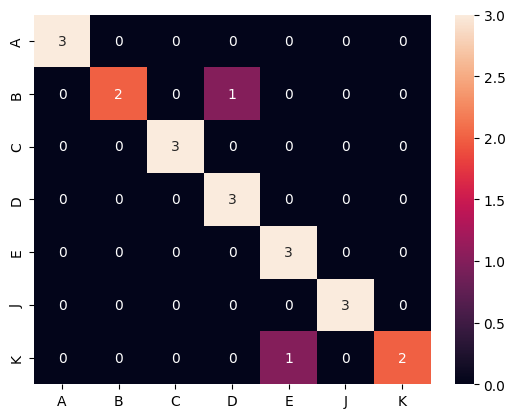

In [384]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_test_label = label(y_test, labels)
predictions_label = label(predictions, labels)

cm = confusion_matrix(y_test_label, predictions_label, labels=labels)

sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels)

In [385]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

accuracy = accuracy_score(y_test_label, predictions_label)
precision = pd.DataFrame(precision_score(y_test_label, predictions_label, average=None, zero_division=0.0), index=labels, columns=['precision'])
recall = pd.DataFrame(recall_score(y_test_label, predictions_label, average=None), index=labels, columns=['recall'])
f1 = pd.DataFrame(f1_score(y_test_label, predictions_label, average=None), index=labels, columns=['f1'])

metrics = precision.join(recall) 
metrics = metrics.join(f1) 

print("accuracy:", accuracy)
metrics.head(7)

accuracy: 0.9047619047619048


,precision,recall,f1
A,1.00,1.000000,1.000000
B,1.00,0.666667,0.800000
C,1.00,1.000000,1.000000
D,0.75,1.000000,0.857143
E,0.75,1.000000,0.857143
J,1.00,1.000000,1.000000
K,1.00,0.666667,0.800000
